In [1]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2
from qiskit.visualization import plot_histogram

In [2]:
n = 2
n_cube = pow(n, 3)
qb_per_process = int(np.ceil(np.log2(n_cube)))
total_qubits = n * qb_per_process

def generate_leader_circuit():
    qc = QuantumCircuit(total_qubits)
    qc.h(range(0, qb_per_process))

    for j in range(1,n):
        for i in range(0, qb_per_process):
            qc.cx(i, i + j * qb_per_process)
    qc.measure_all()
    return qc

def generate_coin_circuit():
    qc = QuantumCircuit(n)
    qc.h(0)
    qc.cx(0,range(1,n))
    qc.measure_all()    
    return qc

def measure_circuit_sampler(system):
    aer_sim = AerSimulator(method="stabilizer")
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
    isa_qc = pm.run(system)
    sampler = SamplerV2(backend=aer_sim)

    result = sampler.run([isa_qc], shots=None).result() # PubResult
    data_pub = result[0].data   # DataBin
    shots = data_pub.meas.num_shots
    counts = data_pub.meas.get_counts()  

    probs = {string:count/shots for string,count in counts.items()}
    return probs

In [3]:
leader_circuit = generate_leader_circuit()
#leader_circuit.draw(output="latex_source")  # For thesis report
leader_circuit.draw(output="text")

┌───┐                ░ ┌─┐               
   q_0: ┤ H ├──■─────────────░─┤M├───────────────
        ├───┤  │             ░ └╥┘┌─┐            
   q_1: ┤ H ├──┼────■────────░──╫─┤M├────────────
        ├───┤  │    │        ░  ║ └╥┘┌─┐         
   q_2: ┤ H ├──┼────┼────■───░──╫──╫─┤M├─────────
        └───┘┌─┴─┐  │    │   ░  ║  ║ └╥┘┌─┐      
   q_3: ─────┤ X ├──┼────┼───░──╫──╫──╫─┤M├──────
             └───┘┌─┴─┐  │   ░  ║  ║  ║ └╥┘┌─┐   
   q_4: ──────────┤ X ├──┼───░──╫──╫──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║  ║  ║ └╥┘┌─┐
   q_5: ───────────────┤ X ├─░──╫──╫──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║  ║  ║ └╥┘
meas: 6/════════════════════════╩══╩══╩══╩══╩══╩═
                                0  1  2  3  4  5

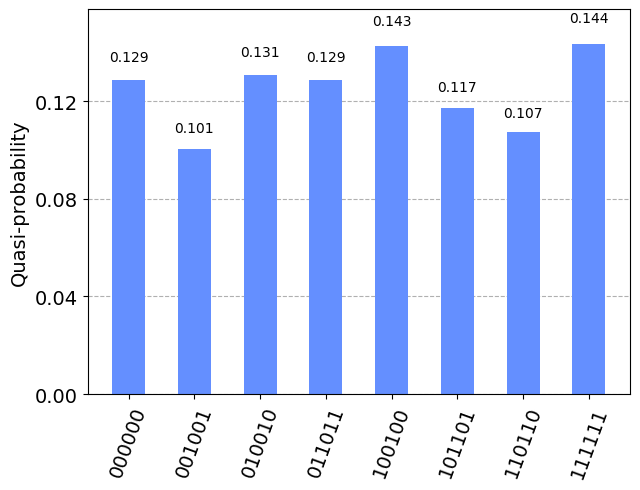

In [4]:
probabilities = measure_circuit_sampler(leader_circuit)
plot_histogram(probabilities, figsize=(7,5))

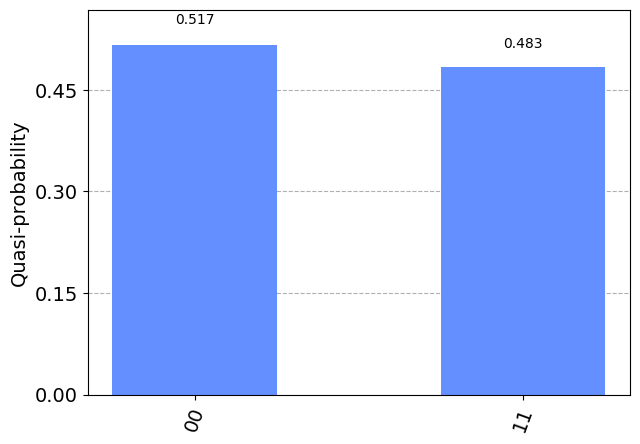

In [5]:
coin_circuit = generate_coin_circuit()
probs2 = measure_circuit_sampler(coin_circuit)
plot_histogram(probs2)